In [1]:
import pandas as pd
import pyarrow.parquet as pq
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.fftpack import fft, ifft
import scipy.integrate as integrate

from tqdm import trange
import gc
import seaborn as sns
from tqdm import tqdm

from sklearn import model_selection

from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from scipy import fftpack

from bokeh.plotting import figure,show,output_file, ColumnDataSource
from bokeh.io import push_notebook, output_notebook
from bokeh.layouts import column

from sklearn.model_selection import KFold
import lightgbm as lgb


from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import peakutils

from numpy.fft import rfft, rfftfreq, irfft
from sklearn.metrics import matthews_corrcoef as mcc


output_notebook()

/usr/local/opt/pyenv/versions/3.6.4/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Loading BokehJS ...

In [2]:
%%time
meta_train = pd.read_csv('input/metadata_train.csv')
raw_train = pq.read_pandas('input/train.parquet').to_pandas()

CPU times: user 2min 7s, sys: 55.4 s, total: 3min 2s
Wall time: 49 s


In [3]:
R = 0.02 #range of data sample in seconds
N_measurements = 8e5 #number of measurements in one cycle
D_0 = R/N_measurements #how often the signal is sampled


print('Sampling delta: {} ns'.format(D_0 * 1e9))
print('Sampling frequency: {} MHz'.format(1/(D_0 * 1e6)))
print('\n')
print('Nyquist frequency (f_max): {} MHz'.format(1/(D_0 * 1e6)/2))
print('Min frequency (f_min and also minimum discernible frequency gap): {} Hz'.format(1/R))

Sampling delta: 25.0 ns
Sampling frequency: 40.0 MHz


Nyquist frequency (f_max): 20.0 MHz
Min frequency (f_min and also minimum discernible frequency gap): 50.0 Hz


In [4]:
def fft_peaks(time_series, buckets = 100, stdevs = 0.7):
    FFT = abs(fftpack.fft(time_series))
    FFT[FFT < FFT.std() * stdevs] = 0
    
    freq_range = FFT.shape[0]//2
    buck_size = int(np.ceil((freq_range)/(buckets)))
    
    min_freq = 50
    
    segments = [(i,i+buck_size) for i in range(min_freq, freq_range, buck_size)]
    fft_components = [np.sum(FFT[ind_[0]:ind_[1]]) for ind_ in segments]
    fft_components = [(item/max(fft_components))*100 for item in fft_components]
    fft_ranges = [(int(ind_[0]*5e-2), int(ind_[1]*5e-2)) for ind_ in segments]
    
    return fft_components, fft_ranges
    

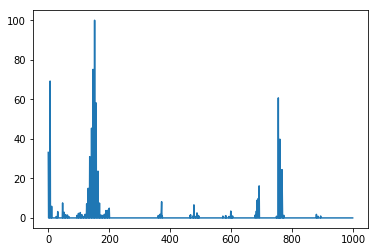

In [5]:
plt.plot(fft_peaks(raw_train['421'], 1000)[0])
plt.show()

In [6]:
def generate_fourier_dataset(train_set, meta_train, buckets):
    train_length = meta_train.shape[0]
    positive_length = len(meta_train[meta_train.target == 1])
    hand_features = ['mean','max','min','std']
    
    dataset = np.zeros((train_length, len(hand_features) + buckets + 2))
    imbalance_ = positive_length / train_length
    
    row_index = 0
    for i in trange(train_length):
#         if meta_train.loc[i, 'target'] == 1 or (random.random() < imbalance_):
        spectrum = train_set[str(i)]

        fft_integrals, fft_ranges = fft_peaks(spectrum, buckets)

        features_temp = np.array([spectrum.mean(), spectrum.max(), spectrum.min(), spectrum.std()] 
                            + fft_integrals)

        label_temp = meta_train.loc[i, 'target']
        measurement_id = meta_train.loc[i, 'id_measurement']
        phase = meta_train.loc[i, 'phase']

        dataset[row_index,:] = np.concatenate([features_temp, [phase, label_temp]])

        row_index += 1
    
    
    #discard zeros
    tmp_ = np.sum(dataset, axis=1)
    nzv = len(tmp_[tmp_ != 0])
    
    return pd.DataFrame(columns= hand_features + ['ft_' + str(ran[1]) + str('GHz') for ran in fft_ranges] 
                        + ['phase', 'label'], 
                        data = dataset[0:nzv,:])

In [7]:
def generate_fourier_dataset_test(test_set, meta_test, buckets):
    test_length = meta_test.shape[0]
    hand_features = ['mean','max','min','std']
    
    dataset = np.zeros((test_length, len(hand_features) + buckets + 1))
    
    row_index = 0
    for i in trange(test_length):
        spectrum = test_set[str(i + 8712)]

        fft_integrals, fft_ranges = fft_peaks(spectrum, buckets)

        features_temp = np.array([spectrum.mean(), spectrum.max(), spectrum.min(), spectrum.std()] 
                            + fft_integrals)
        measurement_id = meta_test.loc[i, 'id_measurement']
        phase = meta_test.loc[i, 'phase']
        
        dataset[row_index,:] = np.concatenate([features_temp, [phase]])
    
        row_index += 1
        
    return pd.DataFrame(columns= hand_features + ['ft_' + str(ran[1]) + str('GHz') for ran in fft_ranges] 
                        + ['phase'],
                        data = dataset)

In [8]:
%%time
train = generate_fourier_dataset(raw_train, meta_train, 10)


print('Train length: {}'.format(len(train)))
print('Positive length: {}'.format(len(train[train.label == 1])))


100%|██████████| 8712/8712 [08:55<00:00, 16.57it/s]

Train length: 8712
Positive length: 525
CPU times: user 8min 21s, sys: 35 s, total: 8min 56s
Wall time: 8min 55s


In [9]:
def mcc_scorer(truth, pred):
    pred = np.round(pred)
    MCC = mcc(truth, pred)
    return MCC

my_mcc_scorer = make_scorer(mcc_scorer, greater_is_better=True)

In [10]:
BaseEstimator = RandomForestClassifier(class_weight = 'balanced')

pg = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7],
    'criterion' :['gini', 'entropy']
}

GridSearchBase = model_selection.GridSearchCV(BaseEstimator, 
                                              param_grid=pg,
                                              cv = 4,
                                              n_jobs=1,
                                              verbose=2, 
                                              scoring=my_mcc_scorer)

In [11]:
Y = train['label']
X = train.drop(['label'], axis=1)
features = X.columns

In [12]:
GridSearchBase.fit(X,Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 72 candidates, totalling 288 fits
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=200 
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=200, total=   0.9s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=200 
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=200, total=   0.8s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=200 
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=200, total=   0.9s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=200 
[CV]  criterion=gini, max_depth=4, max_features=auto, n_es

[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200, total=   1.0s
[CV] criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200, total=   1.0s
[CV] criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500, total=   2.4s
[CV] criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500, total=   2.4s
[CV] criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500, total=   2.4s
[CV] criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500 
[CV]  criterion=gini, max_depth=5, max_features=sqrt, n_estimators=500, total=   2.4s
[CV] criterion=gini, max_depth=5, max_features=log2, n_estimators=100 
[CV]  criterion=gini, max_depth=5, max_features=log2, n_es

[CV]  criterion=gini, max_depth=6, max_features=log2, n_estimators=500, total=   2.6s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=7, max_features=auto, n_estimators=100, total=   0.6s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=7, max_features=auto, n_estimators=100, total=   0.6s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=7, max_features=auto, n_estimators=100, total=   0.6s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=7, max_features=auto, n_estimators=100, total=   0.6s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=200 
[CV]  criterion=gini, max_depth=7, max_features=auto, n_estimators=200, total=   1.1s
[CV] criterion=gini, max_depth=7, max_features=auto, n_estimators=200 
[CV]  criterion=gini, max_depth=7, max_features=auto, n_es

[CV]  criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=100, total=   0.6s
[CV] criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200 
[CV]  criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200, total=   1.1s
[CV] criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200 
[CV]  criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200, total=   1.1s
[CV] criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200 
[CV]  criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200, total=   1.1s
[CV] criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200 
[CV]  criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200, total=   1.1s
[CV] criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=500 
[CV]  criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=500, total=   2.7s
[CV] criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=500 
[CV]  criterion=entrop

[CV]  criterion=entropy, max_depth=5, max_features=log2, n_estimators=200, total=   1.2s
[CV] criterion=entropy, max_depth=5, max_features=log2, n_estimators=200 
[CV]  criterion=entropy, max_depth=5, max_features=log2, n_estimators=200, total=   1.2s
[CV] criterion=entropy, max_depth=5, max_features=log2, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=log2, n_estimators=500, total=   3.1s
[CV] criterion=entropy, max_depth=5, max_features=log2, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=log2, n_estimators=500, total=   3.1s
[CV] criterion=entropy, max_depth=5, max_features=log2, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=log2, n_estimators=500, total=   3.1s
[CV] criterion=entropy, max_depth=5, max_features=log2, n_estimators=500 
[CV]  criterion=entropy, max_depth=5, max_features=log2, n_estimators=500, total=   3.1s
[CV] criterion=entropy, max_depth=6, max_features=auto, n_estimators=100 
[CV]  criterion=entrop

[CV]  criterion=entropy, max_depth=7, max_features=auto, n_estimators=500, total=   3.7s
[CV] criterion=entropy, max_depth=7, max_features=auto, n_estimators=500 
[CV]  criterion=entropy, max_depth=7, max_features=auto, n_estimators=500, total=   3.7s
[CV] criterion=entropy, max_depth=7, max_features=auto, n_estimators=500 
[CV]  criterion=entropy, max_depth=7, max_features=auto, n_estimators=500, total=   3.6s
[CV] criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 
[CV]  criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, total=   0.7s
[CV] criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 
[CV]  criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, total=   0.7s
[CV] criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 
[CV]  criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100, total=   0.7s
[CV] criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100 
[CV]  criterion=entrop

[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  8.0min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mcc_scorer), verbose=2)

In [13]:
GridSearchBase.best_score_

0.37188318580020774

In [14]:
predictor = GridSearchBase.best_estimator_

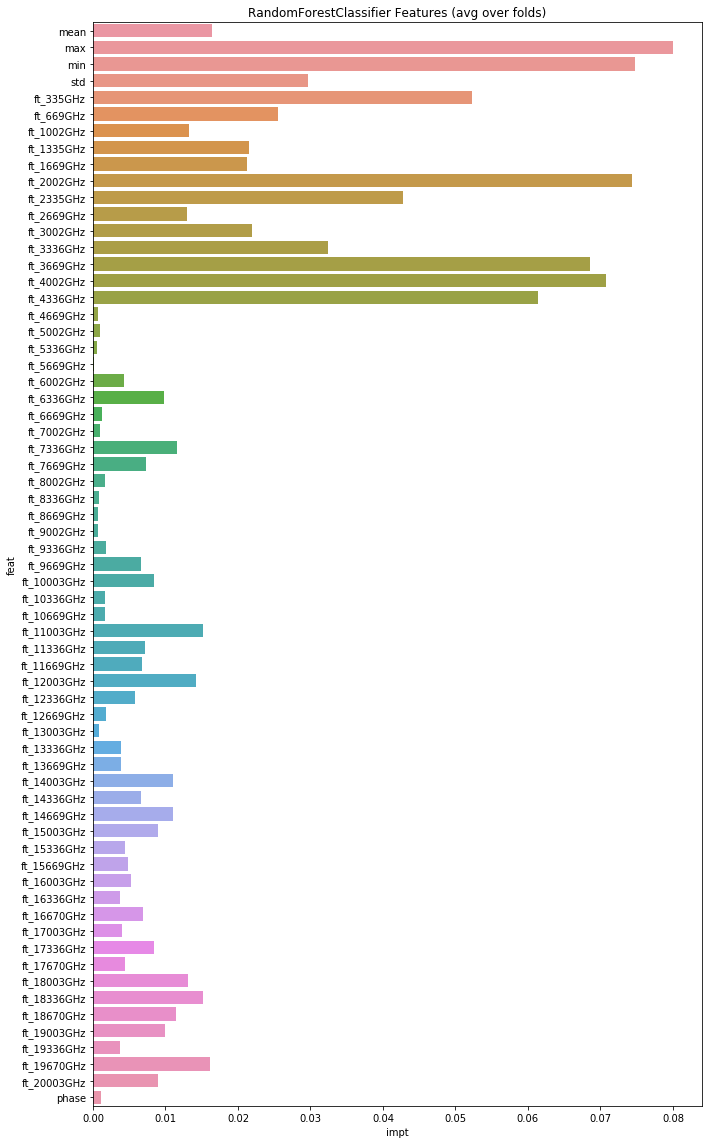

In [15]:
plt.figure(figsize=(10,16))

dd=pd.DataFrame(columns = X.columns, data = [predictor.feature_importances_]).T
dd = dd.reset_index()
dd.columns = ['feat','impt']

sns.barplot(x="impt",
            y="feat",
            data=dd)
plt.title('RandomForestClassifier Features (avg over folds)')
plt.tight_layout()

In [16]:
gc.collect()

13130

# Predict and Submit

In [17]:
%%time
meta_test = pd.read_csv('input/metadata_test.csv')

CPU times: user 10.6 ms, sys: 4.52 ms, total: 15.1 ms
Wall time: 14.2 ms


In [18]:
%%time
meta_test = pd.read_csv('input/metadata_test.csv')
subset_test = pq.read_pandas('input/test.parquet').to_pandas()

CPU times: user 4min 54s, sys: 2min 30s, total: 7min 25s
Wall time: 3min 41s


In [19]:
%%time
test = generate_fourier_dataset_test(subset_test, meta_test, 60)
print('Train length: {}'.format(len(test)))


100%|██████████| 20337/20337 [22:57<00:00, 14.85it/s]

Train length: 20337
CPU times: user 20min 17s, sys: 2min 12s, total: 22min 29s
Wall time: 22min 57s


In [20]:
test.to_csv("test.csv", index=False)

In [21]:
x_filename = meta_test.signal_id
predictions = predictor.predict(test)

In [22]:
sub_df = pd.DataFrame({"signal_id":x_filename.values})
sub_df["target"] = pd.Series(predictions).round()
sub_df['signal_id'] = sub_df['signal_id'].astype(np.int64)
sub_df['target'] = sub_df['target'].astype(np.int64)
sub_df.to_csv("submission_twelve.csv", index=False)
sub_df

,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0
5,8717,0
6,8718,0
7,8719,0
8,8720,0
9,8721,0


In [23]:
positive = len(sub_df[sub_df["target"] == 1])
print('Predicted positive: {}. {}% of total.'.format(positive, positive/len(sub_df)*100))

Predicted positive: 1775. 8.727934306928258% of total.
